# Capstone Project 1: Instacart Market Basket Analysis
## Part 2: Predicting Customer's Diet Classification

Part 1 of this Project is the Exploratory Data Analysis where a list of questions where answered about the dataset.  This part two section includes:

1. overall Aisle Perent distribution calculation
2. extracting three sample dataset from customer's order history
3. identifying Diet Classification by USERS
4. identifying Diet Classification by ORDERS
5. generating simulated sample data set
6. hypothesis testing part 1: Are there significant differences between Diet distributions classified by USERS vs. by ORDERS?
7. hypothesis testing part 2: Are there significant differences between Diet distribution classified by USERS and by ORDERS   
   using Empirical dataset vs. Simulated dataset 
8. Limitations of this algorithm

Note: Headings that start with "F" (F1,F2,...Fn) are functions

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
% matplotlib inline
import seaborn as sns
from matplotlib import rcParams
from scipy import stats
sns.set(style="whitegrid", color_codes=True)
sns.set_context("poster")

In [2]:
## Read and Save all Tables in a DF
prod=pd.read_csv('products.csv')
aisles=pd.read_csv('aisles.csv')
dep=pd.read_csv('departments.csv')
orders=pd.read_csv('orders.csv')
train=pd.read_csv('order_products__train.csv')
prior=pd.read_csv('order_products__prior.csv')
samp=pd.read_csv('sample_submission.csv')

In [3]:
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [4]:
## Orders Table Separated to three
oprior=orders[orders.eval_set=='prior']
otrain=orders[orders.eval_set=='train']
otest=orders[orders.eval_set=='test']

In [5]:
oprior.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [6]:
## Total number of Customers that are in oprior dataframe
oprior.user_id.unique().size

206209

In [7]:
##Merging Oprior DataFrame with prod and aisle dataframes
Allprior=oprior.merge(prior)
Allprior=Allprior.merge(prod)
Allprior=Allprior.merge(aisles)

# 1. Overall Aisle Perent distribution calculation

In [8]:
##Percentage of orders coming from each aisle in the entire Allprior dataframe
aisle_percent=Allprior.aisle_id.value_counts()/Allprior.aisle_id.size
aisle_percent=pd.DataFrame(aisle_percent).sort_index().reset_index()
aisle_percent.columns=['aisle_id', 'aisle_percent']
aisle_percent.head()


,aisle_id,aisle_percent
0,1,0.002218
1,2,0.002543
2,3,0.014071
3,4,0.006187
4,5,0.001927


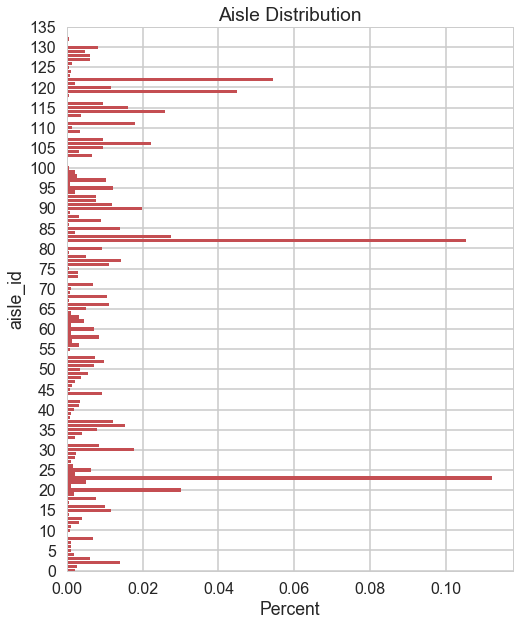

In [9]:
fig, ax = plt.subplots(figsize=(8,10))
plt.barh(range(len(aisle_percent.aisle_percent)), aisle_percent.aisle_percent, color='r')
plt.ylim(0,135)
plt.xlabel('Percent')
plt.ylabel('aisle_id')
plt.title('Aisle Distribution')
ax.set_yticks(np.arange(0,136,5))
plt.show()

In [10]:
## U is the dataframe of users with their number of orders
U=oprior.groupby('user_id')['order_number'].agg(['max'])
U['user_id']=U.index.get_level_values('user_id').values
U.columns=['max_order', 'user_id']

In [11]:
## P_num is the dataframe of users with order_id and the number of products per order
P_num=Allprior.groupby('user_id')['order_id'].value_counts()
P_num=pd.DataFrame(P_num)
P_num.columns=['prod_per_order']
P_num['user_id']=P_num.index.get_level_values('user_id').values
P_num['order_id']=P_num.index.get_level_values('order_id').values

In [12]:
### Tot_p is the dataframe of users with total number of products they ordered
Tot_p=Allprior.user_id.value_counts()
Tot_p=pd.DataFrame(Tot_p).reset_index()
Tot_p.columns=['user_id', 'total_products']

##  F1. This function provides a sample of 10,000 random users from the oprior dataframe for training dataset

In [13]:
def Sample_maker(Q):
    PO=Q.merge(P_num).merge(Tot_p)
    sample1=Q.sample(n=10000, replace=False, random_state=0, axis=0)
    
    ## sample1 is the DataFrame of the first dataset
    sample1=sample1.merge(PO, how='inner')
    sample1=sample1.loc[:,['user_id', 'order_id', 'max_order', 'prod_per_order', 'total_products']]


    #Emp is the Empirical dataframe
    Emp=sample1.merge(Allprior, how='inner')
    
    return Emp

## F2. This Function classifies Users as Meat_Lovers, Pescatarian, Vegan, NonVegan according to users overall order history

In [14]:
def Diet_Class_user(A):
    ## Total products ordered from Meat & Seafood Aisles
    MS=A[(A.aisle_id==5)|(A.aisle_id==7)|(A.aisle_id==15)|(A.aisle_id==34)|(A.aisle_id==35)|(A.aisle_id==39)|(A.aisle_id==49)|(A.aisle_id==95)|(A.aisle_id==96)|(A.aisle_id==106)|(A.aisle_id==122)]
    
    ##Eats Meat and Fish
    M=MS[(MS.aisle_id==5)|(A.aisle_id==7)|(A.aisle_id==35)|(A.aisle_id==49)|(A.aisle_id==96)|(A.aisle_id==106)|(A.aisle_id==122)]
    MF=M.user_id.unique()
    Meat_L=pd.DataFrame(MF, columns=['user_id'])
    Meat_L['Diet']='Meat_Lovers'
    
    ##Pescatarian that eat and not eat other meat
    P=MS[(MS.aisle_id==15)|(MS.aisle_id==34)|(MS.aisle_id==39)|(MS.aisle_id==95)]
    F=P.user_id.unique()
    
    ## Pescatarian customers
    Pesca=np.setdiff1d(F,MF)
    Pesca=pd.DataFrame(Pesca, columns=['user_id'])
    Pesca['Diet']='Pescatarian'

    ## All Vegetarians
    Veg=A.loc[~A.user_id.isin(MS.user_id)]

    # NonVegan 
    NV=Veg[(Veg.aisle_id==86)|(Veg.aisle_id==2)|(Veg.aisle_id==21)|(Veg.aisle_id==53)|(Veg.aisle_id==84)|(Veg.aisle_id==108)|(Veg.aisle_id==120)]
    F1=NV.user_id.unique()

    NonVeg=pd.DataFrame(F1, columns=['user_id'])
    NonVeg['Diet']='NonVegan'
    
    ##Vegans
    Vegans=Veg.loc[~Veg.user_id.isin(F1)]
    Vega=Vegans.user_id.unique()
    Vega=pd.DataFrame(Vega, columns=['user_id'])
    Vega['Diet']='Vegan'
    
    ## Merge all DataFrame of Different Diets
    Sample_class=pd.concat([Meat_L, Pesca, NonVeg, Vega])
    
    return Sample_class

## F3. This Function classifies Meat_Lovers, Pescatarian, Vegan, NonVegan according to orders and disregarding who ordered it (the user)

In [15]:
def Diet_Class_orders(A):
    ## Total products ordered from Meat & Seafood Aisles
    MS=A[(A.aisle_id==5)|(A.aisle_id==7)|(A.aisle_id==15)|(A.aisle_id==34)|(A.aisle_id==35)|(A.aisle_id==39)|(A.aisle_id==49)|(A.aisle_id==95)|(A.aisle_id==96)|(A.aisle_id==106)|(A.aisle_id==122)]
    
    ##Eats Meat and Fish
    M=MS[(MS.aisle_id==5)|(A.aisle_id==7)|(A.aisle_id==35)|(A.aisle_id==49)|(A.aisle_id==96)|(A.aisle_id==106)|(A.aisle_id==122)]
    MF=M.order_id.unique()
    Meat_L=pd.DataFrame(MF, columns=['order_id'])
    Meat_L['Diet']='Meat_Lovers'
    
    ##Pescatarian that eat and not eat other meat
    P=MS[(MS.aisle_id==15)|(MS.aisle_id==34)|(MS.aisle_id==39)|(MS.aisle_id==95)]
    F=P.order_id.unique()
    
    ## Pescatarian customers
    Pesca=np.setdiff1d(F,MF)
    Pesca=pd.DataFrame(Pesca, columns=['order_id'])
    Pesca['Diet']='Pescatarian'

    ## All Vegetarians
    Veg=A.loc[~A.order_id.isin(MS.order_id)]

    # NonVegan 
    NV=Veg[(Veg.aisle_id==86)|(Veg.aisle_id==2)|(Veg.aisle_id==21)|(Veg.aisle_id==53)|(Veg.aisle_id==84)|(Veg.aisle_id==108)|(Veg.aisle_id==120)]
    F1=NV.order_id.unique()

    NonVeg=pd.DataFrame(F1, columns=['order_id'])
    NonVeg['Diet']='NonVegan'
    
    ##Vegans
    Vegans=Veg.loc[~Veg.order_id.isin(F1)]
    Vega=Vegans.order_id.unique()
    Vega=pd.DataFrame(Vega, columns=['order_id'])
    Vega['Diet']='Vegan'
    
    ## Merge all DataFrame of Different Diets
    Sample_class=pd.concat([Meat_L, Pesca, NonVeg, Vega])
    
    return Sample_class

## F4. This function returns a horizontal bar graph of distrubution of the four Diet Categories of Customers 

In [16]:
def Diet_Percentage(B):
    Per=B.Diet.value_counts()
    Per=pd.DataFrame(Per).reset_index()
    Per.columns=['Diet','Size']
    Per['Percent']=Per.Size/Per.Size.sum()
    
    #Bar=Per.sort_index().plot(kind='barh', color='r')
    #plt.xlabel('Percentage')
    #plt.title('Customer Diet Distribution')
    return Per

## F5. This function excludes the 10,000 users previously used in a training dataset 

In [17]:
def Remaining_users(S): ## S is an Empirical Sample Generated DataFrame (E1, E2, E3)
    Rem=U.loc[~U.user_id.isin(S.user_id)]
    return Rem
    

## 2. Extracting three empirical sample dataset from customer's order history 
### E1, E2 and E3 are the 3 Empirical Samples each with 10,000 users are extracted

## 3. Identifying Diet Classification by USERS
### P_user1, P_user2, P_user3 are the USERS FROM E1,E2 and E3 dataframe with classified USERS Diet

In [18]:
## First Empirical Sample with 10,000 users from oprior DataFrame

E1=Sample_maker(U)           # Empirical Sample Generated
C1=Diet_Class_user(E1)       # Diets are of 10,000 in the Empirical Sample Classified by USERS
P_user1=Diet_Percentage(C1) # This returns the percentage of the different Diet Classification
P_user1

C:\Users\pamel\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


,Diet,Size,Percent
0,Meat_Lovers,6426,0.6426
1,NonVegan,2336,0.2336
2,Vegan,774,0.0774
3,Pescatarian,464,0.0464


In [19]:
## Second Empirical Sample with 10,000 users from oprior DataFrame
U1=Remaining_users(E1)      # The 10,000 users in the first Emprical Sample (E1) is excluded from the oprior DataFrame

E2=Sample_maker(U1)         # Empirical Sample Generated
C2=Diet_Class_user(E2)      # Diets are of 10,000 in the Empirical Sample Classified
P_user2=Diet_Percentage(C2)      # This returns the percentage of the different Diet Classification
P_user2

C:\Users\pamel\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


,Diet,Size,Percent
0,Meat_Lovers,6517,0.6517
1,NonVegan,2294,0.2294
2,Vegan,691,0.0691
3,Pescatarian,498,0.0498


In [20]:
## Third Empirical Sample with 10,000 users from oprior DataFrame

ET=pd.concat([E1,E2])           # The first two Empirical Sample were merged a
U2=Remaining_users(ET)      # The 10,000 users in the first and second Emprical Sample (E1+E2) is excluded from the oprior DataFrame
E3=Sample_maker(U2)         # Empirical Sample Generated
C3=Diet_Class_user(E3)      # Diets are of 10,000 in the Empirical Sample Classified
P_user3=Diet_Percentage(C3)      # This returns the percentage of the different Diet Classification
P_user3

C:\Users\pamel\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


,Diet,Size,Percent
0,Meat_Lovers,6511,0.6511
1,NonVegan,2335,0.2335
2,Vegan,676,0.0676
3,Pescatarian,478,0.0478


## Bar Graph Comparison of % Diet Classification according to USERS across three Empirical Sample Datasets

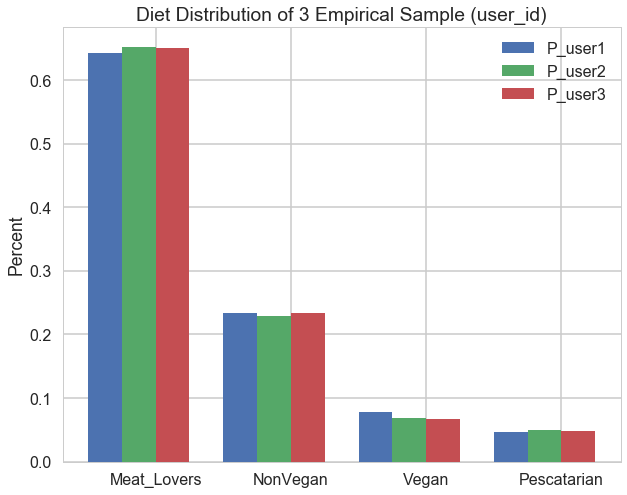

In [21]:
fig, ax = plt.subplots(figsize=(10,8))

X = np.arange(4)
plt.bar(X + 0.00, P_user1.Percent, color = 'b', width = 0.25)
plt.bar(X + 0.25, P_user2.Percent, color = 'g', width = 0.25)
plt.bar(X + 0.50, P_user3.Percent, color = 'r', width = 0.25)
plt.ylabel('Percent')

ax.set_xticks([p + 1.5 * 0.25 for p in X])
ax.set_xticklabels(P_user1.Diet)

plt.legend(['P_user1', 'P_user2', 'P_user3'], loc='upper right')
plt.title('Diet Distribution of 3 Empirical Sample (user_id)')
plt.show()

## 4. Identifying Diet Classification by ORDERS

In [22]:
## Reclassification of Diets using E1 with 154162 total orders
C_order1=Diet_Class_orders(E1)       # Diets are classified per order_id
P_order1=Diet_Percentage(C_order1)   # This returns the percentage and a bar graph distribution of the different Diet Classification
P_order1

C:\Users\pamel\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


,Diet,Size,Percent
0,NonVegan,61868,0.401318
1,Vegan,49542,0.321363
2,Meat_Lovers,37813,0.245281
3,Pescatarian,4939,0.032038


In [23]:
## Reclassification of Diets using E2 with 156542
C_order2=Diet_Class_orders(E2)          # Diets are classified per order_id
P_order2=Diet_Percentage(C_order2)      # This returns the percentage of the different Diet Classification
P_order2

C:\Users\pamel\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


,Diet,Size,Percent
0,NonVegan,62354,0.398321
1,Vegan,49480,0.316081
2,Meat_Lovers,39572,0.252788
3,Pescatarian,5136,0.032809


In [24]:
## Reclassification of Diets using E3 with 157384 total orders
C_order3=Diet_Class_orders(E3)          # Diets are classified per order_id
P_order3=Diet_Percentage(C_order3)      # This returns the percentage of the different Diet Classification
P_order3

C:\Users\pamel\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


,Diet,Size,Percent
0,NonVegan,63624,0.404260
1,Vegan,50124,0.318482
2,Meat_Lovers,38783,0.246423
3,Pescatarian,4853,0.030835


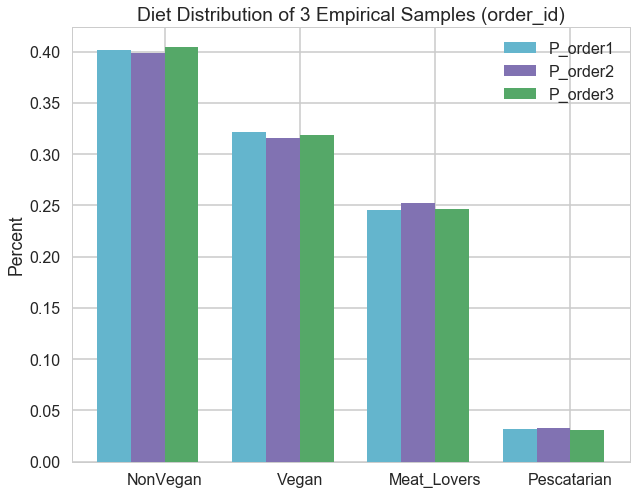

In [25]:
## Bar Graph comparison of Diet distribution using Empirical Samples classified using ORDERS
fig, ax = plt.subplots(figsize=(10,8))

X = np.arange(4)
plt.bar(X + 0.00, P_order1.Percent, color = 'c', width = 0.25)
plt.bar(X + 0.25, P_order2.Percent, color = 'm', width = 0.25)
plt.bar(X + 0.50, P_order3.Percent, color = 'g', width = 0.25)
plt.ylabel('Percent')

ax.set_xticks([p + 1.5 * 0.25 for p in X])
ax.set_xticklabels(P_order1.Diet)

plt.legend(['P_order1', 'P_order2', 'P_order3'], loc='upper right')
plt.title('Diet Distribution of 3 Empirical Samples (order_id)')
plt.show()




## 5. Generating simulated sample data set
## F6. This function generates simulated sample dataframe

In [26]:
def Simulated_sample(S):  # S isn an empirical sample generated dataframe (E1,E2, E3)
    G=S.loc[:, ['user_id', 'order_id', 'prod_per_order']]
    G=G.drop_duplicates()
    
    ## G.prod_per_order is turned into a list n.  n will be used on a loop to generate a simulated order dataframe
    n=pd.Series.tolist(G.prod_per_order)

    ## This will generate the simulated orders where aisle is randomly picked accoring to its calculated probability or percentage from aisle_percent dataframe
    B=[]
    for i in n:
        Q=np.random.choice(a=aisle_percent.aisle_id, size=i, p=aisle_percent.aisle_percent)
        Q=Q.tolist()
        B.append(Q)
    
    ## The simulated list of randomly picked aisles "B" is turned into dataframe 
        
    Sim1=pd.DataFrame(B).reset_index().stack()
    Sim1=pd.DataFrame(Sim1).reset_index()
    Sim1=Sim1.rename(columns={'level_0':'order_id', 'level_1':'product_num', 0:'aisle_id'})
    Sim1=Sim1[Sim1['product_num']!='index']
    Sim1['user_id']=S['user_id']
    
    return Sim1

In [27]:
## This is the first simulated Sample dataframe with randomly picked aisles
Simu1= Simulated_sample(E1)

In [28]:
Csim_or=Diet_Class_orders(Simu1)    #Each order is classified to a certain Diet
Psimulated_order=Diet_Percentage(Csim_or)    #Percentage of each diet is calculated
Psimulated_order


C:\Users\pamel\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


,Diet,Size,Percent
0,NonVegan,65765,0.426597
1,Meat_Lovers,42214,0.273829
2,Vegan,40756,0.264371
3,Pescatarian,5427,0.035203


In [29]:
Csim_us=Diet_Class_user(Simu1)    ## Each user is classified to a certain Diet
Psimulated_user=Diet_Percentage(Csim_us) ## Percentage of each diet calculated
Psimulated_user

C:\Users\pamel\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


,Diet,Size,Percent
0,Meat_Lovers,8199,0.819572
1,NonVegan,1397,0.139644
2,Pescatarian,240,0.023990
3,Vegan,168,0.016793


## F7. This function will merge two dataframes from two group of proportions being compared 

In [30]:
## This function will merge two dataframes from two group of proportions being compared 
def df_prop_compare(M, N):    ## M and N are dataframes with Diet classification with Size and Percent
    M.columns=['Diet', 'Size1', 'Percent1']
    N.columns=['Diet', 'Size2', 'Percent2']
    MN=M.merge(N)
    return MN

In [31]:
## User_Order_Emp is the dataframe with Sizes and Percentages of Diets classifications from all "users" and "orders"
User_Order_Emp=df_prop_compare(P_user1, P_order1)
User_Order_Emp

,Diet,Size1,Percent1,Size2,Percent2
0,Meat_Lovers,6426,0.6426,37813,0.245281
1,NonVegan,2336,0.2336,61868,0.401318
2,Vegan,774,0.0774,49542,0.321363
3,Pescatarian,464,0.0464,4939,0.032038


## 6. Hypothesis testing part 1: Are there significant differences between Diet distributions classified by USERS vs. by ORDERS? 

Ho: There is no significant difference in classifying Diets using "users overall orders" versus using "individual orders disregarding who ordered it"

H1:There is significant difference in classifying Diets between using "users overall orders" versus using "individual orders disregarding who ordered it"   

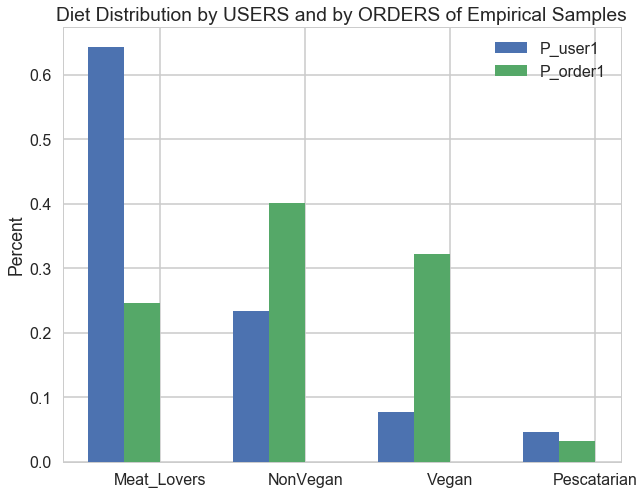

In [32]:
fig, ax = plt.subplots(figsize=(10,8))

X = np.arange(4)
plt.bar(X + 0.00, User_Order_Emp.Percent1, color = 'b', width = 0.25)
plt.bar(X + 0.25, User_Order_Emp.Percent2, color = 'g', width = 0.25)
plt.ylabel('Percent')

ax.set_xticks([p + 1.5 * 0.25 for p in X])
ax.set_xticklabels(User_Order_Emp.Diet)

plt.legend(['P_user1', 'P_order1'], loc='upper right')
plt.title('Diet Distribution by USERS and by ORDERS of Empirical Samples')
plt.show()

##  F8. This function calculates variance, standard deviation, difference in proportion, MOE, degrees of freedom, t_value and p_value 

In [33]:
def diff_std_p_val(W):    ## W is a dataframe with the Diet classification Sizes and Percentages of 2 groups being compared
    W['var_1']=W.Percent1*(1-W.Percent1)/W.Size1
    W['var_2']=W.Percent2*(1-W.Percent2)/W.Size2
    W['var1_2']=W.var_1+W.var_2
    W['std_var1_2']=  W.var1_2**0.5             ## a.k.a. standard error

    W['%_diff']=abs(W.Percent1-W.Percent2)      ## absolute difference between two proportions

    W['moe']=1.96*W.std_var1_2                   ## margin of error

    W['DF']= ((W.var_1/W.Size1 +W.var_2/W.Size2)**2)/(((W.var_1/W.Size1)**2/W.Size1)+((W.var_2/W.Size2)**2/W.Size2))  ## degrees of freedom

    W['t_val']=(W['%_diff']-0)/W.std_var1_2

    W['p_val']=stats.t.sf(np.abs(W.t_val), W.DF)*2  # two-sided pvalue = Prob(abs(t)>tt)

    return W   

In [44]:
## pvalues of Diets % difference between using "users overall orders" and using "individual orders disregarding who ordered 
Use_Or=diff_std_p_val(User_Order_Emp)
Use_Or

,Diet,Size1,Percent1,Size2,Percent2,var_1,var_2,var1_2,std_var1_2,%_diff,moe,DF,t_val,p_val
0,Meat_Lovers,6426,0.6426,37813,0.245281,0.000036,0.000005,0.000041,0.006375,0.397319,0.012494,6728.036494,62.328394,0.000000e+00
1,NonVegan,2336,0.2336,61868,0.401318,0.000077,0.000004,0.000081,0.008973,0.167718,0.017588,2344.946897,18.690405,8.871788e-73
2,Vegan,774,0.0774,49542,0.321363,0.000092,0.000004,0.000097,0.009832,0.243963,0.019270,775.154368,24.813971,1.682779e-100
3,Pescatarian,464,0.0464,4939,0.032038,0.000095,0.000006,0.000102,0.010082,0.014362,0.019760,469.756461,1.424601,1.549365e-01


### For Meat_Lovers, NonVegan, and Vegan, p_values are <0.05, we can reject the null hypothesis and accept H1.  
H1:There is significant difference in classifying these 3 Diets between using "users overall orders" and using "individual orders disregarding who ordered it" .  
However for Pescatarian p_value>0.05 which means there is no significant difference in calculating % of this group by "USERS" or by "ORDERS"

## 7. Hypothesis testing part 2: Are there significant differences between Diet distribution classified by USERS and by ORDERS using Empirical dataset vs. Simulated dataset

II.A
Ho: There is no significant difference between Diet distribution classified by USERS using Empirical dataset versus Simulated dataset

H1: There is significant difference between Diet distribution classified by USERS using Empirical dataset versus Simulated dataset

In [35]:
## Sim_Emp_User is the dataframe comparing % of empirical sample and simulated sample both classified by USERS
Sim_Emp_User=df_prop_compare(P_user1, Psimulated_user)
Sim_Emp_User

,Diet,Size1,Percent1,Size2,Percent2
0,Meat_Lovers,6426,0.6426,8199,0.819572
1,NonVegan,2336,0.2336,1397,0.139644
2,Vegan,774,0.0774,168,0.016793
3,Pescatarian,464,0.0464,240,0.023990


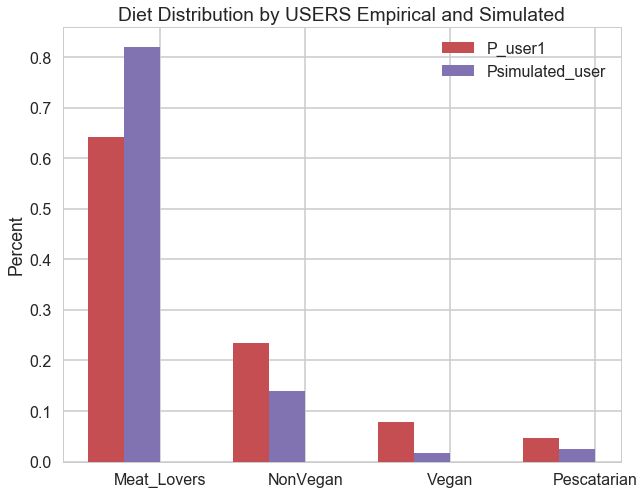

In [36]:
fig, ax = plt.subplots(figsize=(10,8))

X = np.arange(4)
plt.bar(X + 0.00, Sim_Emp_User.Percent1, color = 'r', width = 0.25)
plt.bar(X + 0.25, Sim_Emp_User.Percent2, color = 'm', width = 0.25)
plt.ylabel('Percent')

ax.set_xticks([p + 1.5 * 0.25 for p in X])
ax.set_xticklabels(Sim_Emp_User.Diet)

plt.legend(['P_user1', 'Psimulated_user'], loc='upper right')
plt.title('Diet Distribution by USERS Empirical and Simulated')
plt.show()


In [43]:
##Sim_Emp is a dataframe with calculated standard deviation, moe, degrees of freedom, t_values and p_values (USERS)
Sim_Emp=diff_std_p_val(Sim_Emp_User)
Sim_Emp

,Diet,Size1,Percent1,Size2,Percent2,var_1,var_2,var1_2,std_var1_2,%_diff,moe,DF,t_val,p_val
0,Meat_Lovers,6426,0.6426,8199,0.819572,0.000036,0.000018,0.000054,0.007333,0.176972,0.014373,11147.572447,24.133064,1.798661e-125
1,NonVegan,2336,0.2336,1397,0.139644,0.000077,0.000086,0.000163,0.012753,0.093956,0.024996,2806.163157,7.367304,2.277683e-13
2,Vegan,774,0.0774,168,0.016793,0.000092,0.000098,0.000191,0.013804,0.060607,0.027055,241.262728,4.390623,1.691955e-05
3,Pescatarian,464,0.0464,240,0.023990,0.000095,0.000098,0.000193,0.013890,0.022410,0.027224,480.492026,1.613404,1.073132e-01


### For Meat_Lovers, NonVegan, and Vegan, p_values are <0.05, we can reject the null hypothesis and accept H1.  
H1:There is significant difference between Diet distribution classified by USERS using Empirical dataset versus Simulated dataset. 
However for Pescatarian classified by USERS p_value>0.05 which means there is no significant difference in % of this group using Empirical dataset and Simulated dataset

II.B
Ho: There is no significant difference between Diet distribution classified by ORDERS using Empirical dataset versus Simulated dataset

H1: There is significant difference between Diet distribution classified by ORDERS using Empirical dataset versus Simulated dataset

In [39]:
## Sim_Emp_Order is the dataframe comparing % of empirical sample and simulated sample both classified by ORDERS
Sim_Emp_Order=df_prop_compare(P_order1, Psimulated_order)
Sim_Emp_Order

,Diet,Size1,Percent1,Size2,Percent2
0,NonVegan,61868,0.401318,65765,0.426597
1,Vegan,49542,0.321363,40756,0.264371
2,Meat_Lovers,37813,0.245281,42214,0.273829
3,Pescatarian,4939,0.032038,5427,0.035203


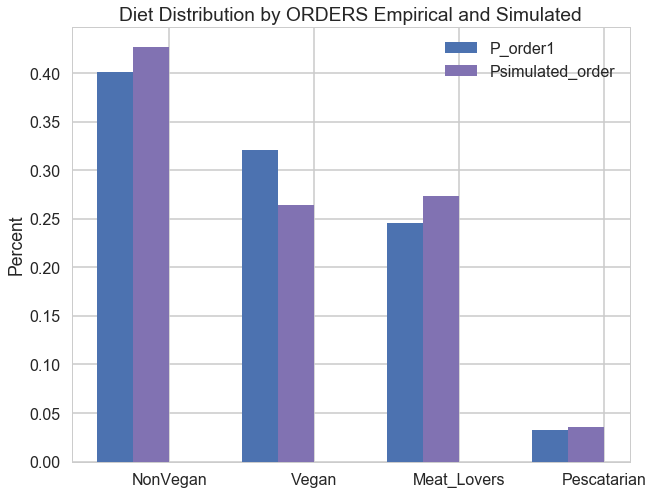

In [40]:
fig, ax = plt.subplots(figsize=(10,8))

X = np.arange(4)
plt.bar(X + 0.00, Sim_Emp_Order.Percent1, color = 'b', width = 0.25)
plt.bar(X + 0.25, Sim_Emp_Order.Percent2, color = 'm', width = 0.25)
plt.ylabel('Percent')

ax.set_xticks([p + 1.5 * 0.25 for p in X])
ax.set_xticklabels(Sim_Emp_Order.Diet)

plt.legend(['P_order1', 'Psimulated_order'], loc='upper right')
plt.title('Diet Distribution by ORDERS Empirical and Simulated')
plt.show()


In [42]:
##Sim_Emp_Order is a dataframe with calculated standard deviation, moe, degrees of freedom, t_values and p_values (ORDERS)
Sim_Emp_Order=diff_std_p_val(Sim_Emp_Order)
Sim_Emp_Order

,Diet,Size1,Percent1,Size2,Percent2,var_1,var_2,var1_2,std_var1_2,%_diff,moe,DF,t_val,p_val
0,NonVegan,61868,0.401318,65765,0.426597,0.000004,0.000004,0.000008,0.002757,0.025279,0.005404,126767.318622,9.167737,4.899879e-20
1,Vegan,49542,0.321363,40756,0.264371,0.000004,0.000005,0.000009,0.003029,0.056992,0.005937,85554.039824,18.816422,7.999529e-79
2,Meat_Lovers,37813,0.245281,42214,0.273829,0.000005,0.000005,0.000010,0.003099,0.028548,0.006075,78709.416825,9.210883,3.311050e-20
3,Pescatarian,4939,0.032038,5427,0.035203,0.000006,0.000006,0.000013,0.003541,0.003166,0.006940,10271.545686,0.894010,3.713376e-01


### For Meat_Lovers, NonVegan, and Vegan, p_values are <0.05, we can reject the null hypothesis and accept H1. 
H1: There is significant difference between Diet distribution classified by ORDERS using Empirical dataset versus Simulated dataset.  
However for Pescatarian classified by ORDERS p_value>0.05 which means there is no significant difference in % of this group using Empirical dataset and Simulated dataset

## 8. Limitations of this algorithm
* This algorithm does not account users that very rarely buy meat but are nonvegans or vegans.  The algorithm will still classify the user as Meat_Lovers as long as they buy any meat.  It will be the same case for users who very rarely buy fish even but are nonvegans or vegans they will be classified as Pescatarian when they buy on the seafood aisle.